# Implementación de DeepFM usando los audio features

In [1]:
import os
import sys
import click
import random
import collections

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import sampler

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from time import time


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preprocesamiento de datos para que coincida con el formato de input de deepFM

Cargamos los datos



In [3]:
train_path = '/content/drive/MyDrive/Colab Notebooks/RecSys/data/training_set.csv'
train_set =  pd.read_csv(train_path)
test_path = '/content/drive/MyDrive/Colab Notebooks/RecSys/data/test_set.csv'
test_set =  pd.read_csv(test_path)

In [4]:
train_set.describe()

,playlist_id,track_id,danceability,energy,key,valence,tempo,target
count,101182.000000,101182.000000,101182.000000,101182.000000,101182.000000,101182.000000,101182.000000,101182.000000
mean,515.149908,17217.659188,0.596922,0.638410,5.182167,0.489205,0.555021,0.502906
std,285.582065,9929.982324,0.162089,0.217599,3.594129,0.239704,0.132746,0.499994
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,264.000000,8662.250000,0.490000,0.496000,2.000000,0.298000,0.451424,0.000000
50%,522.000000,17201.500000,0.605000,0.669000,5.000000,0.481000,0.549821,1.000000
75%,767.000000,25796.000000,0.714000,0.811000,8.000000,0.677000,0.638550,1.000000
max,999.000000,34443.000000,0.988000,1.000000,11.000000,0.998000,1.000000,1.000000


In [5]:
test_set.describe()

,playlist_id,track_id,danceability,energy,key,valence,tempo,target
count,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000
mean,488.590196,17208.604144,0.590267,0.639205,5.174155,0.493315,0.553369,0.201180
std,287.935269,9930.371669,0.163684,0.222572,3.584876,0.244485,0.132772,0.400889
min,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,257.000000,8671.000000,0.484000,0.493750,2.000000,0.298750,0.448191,0.000000
50%,465.000000,17221.000000,0.599000,0.671000,5.000000,0.487000,0.547563,0.000000
75%,721.000000,25787.250000,0.709000,0.817000,8.000000,0.686000,0.638422,0.000000
max,998.000000,34442.000000,0.981000,1.000000,11.000000,0.998000,1.000000,1.000000


In [6]:
train_set.head(5)

,playlist_id,track_id,danceability,energy,key,valence,tempo,target
0,932,2343.0,0.767,0.712,1.0,0.8040,0.565863,1
1,238,17888.0,0.532,0.844,1.0,0.8330,0.386024,1
2,719,12530.0,0.768,0.581,11.0,0.8310,0.366845,1
3,129,16541.0,0.266,0.642,7.0,0.0371,0.342102,0
4,999,33022.0,0.521,0.133,10.0,0.3910,0.638755,1


In [7]:
test_set.head(5)

,playlist_id,track_id,danceability,energy,key,valence,tempo,target
0,365,3650.0,0.521,0.658,11.0,0.235,0.465228,0
1,205,11943.0,0.628,0.698,6.0,0.732,0.410293,1
2,232,18489.0,0.729,0.832,1.0,0.697,0.537914,1
3,918,15310.0,0.458,0.849,3.0,0.389,0.410019,0
4,404,26661.0,0.633,0.573,2.0,0.220,0.692540,0


## Implementación de DeepFM

In [70]:
"""
A pytorch implementation of DeepFM for rates prediction problem.
"""




class DeepFM(nn.Module):
    """
    A DeepFM network with RMSE loss for rates prediction problem.

    There are two parts in the architecture of this network: fm part for low
    order interactions of features and deep part for higher order. In this
    network, we use bachnorm and dropout technology for all hidden layers,
    and "Adam" method for optimazation.

    You may find more details in this paper:
    DeepFM: A Factorization-Machine based Neural Network for CTR Prediction,
    Huifeng Guo, Ruiming Tang, Yunming Yey, Zhenguo Li, Xiuqiang He.
    """

    def __init__(self, feature_sizes, embedding_size=4,
                 hidden_dims=[32, 32], num_classes=1, dropout=[0.5, 0.5],
                 use_cuda=True, verbose=False):
        """
        Initialize a new network

        Inputs:
        - feature_size: A list of integer giving the size of features for each field.
        - embedding_size: An integer giving size of feature embedding.
        - hidden_dims: A list of integer giving the size of each hidden layer.
        - num_classes: An integer giving the number of classes to predict. For example,
                    someone may rate 1,2,3,4 or 5 stars to a film.
        - batch_size: An integer giving size of instances used in each interation.
        - use_cuda: Bool, Using cuda or not
        - verbose: Bool
        """
        super().__init__()
        self.field_size = len(feature_sizes)
        self.feature_sizes = feature_sizes
        self.embedding_size = embedding_size
        self.hidden_dims = hidden_dims
        self.num_classes = num_classes
        self.dtype = torch.long
        self.bias = torch.nn.Parameter(torch.randn(1))
        """
            check if use cuda
        """
        if use_cuda and torch.cuda.is_available():
            self.device = torch.device('cuda')
        else:
            self.device = torch.device('cpu')
        """
            init fm part
        """
        self.fm_first_order_embeddings = nn.ModuleList(
            [nn.Embedding(feature_size, 1) for feature_size in self.feature_sizes])
        self.fm_second_order_embeddings = nn.ModuleList(
            [nn.Embedding(feature_size, self.embedding_size) for feature_size in self.feature_sizes])
        """
            init deep part
        """
        all_dims = [self.field_size * self.embedding_size] + \
            self.hidden_dims + [self.num_classes]
        for i in range(1, len(hidden_dims) + 1):
            setattr(self, 'linear_'+str(i),
                    nn.Linear(all_dims[i-1], all_dims[i]))
            # nn.init.kaiming_normal_(self.fc1.weight)
            setattr(self, 'batchNorm_' + str(i),
                    nn.BatchNorm1d(all_dims[i]))
            setattr(self, 'dropout_'+str(i),
                    nn.Dropout(dropout[i-1]))

    def forward(self, Xi, Xv):
        """
        Forward process of network.

        Inputs:
        - Xi: A tensor of input's index, shape of (N, field_size, 1)
        - Xv: A tensor of input's value, shape of (N, field_size, 1)
        """
        """
            fm part
        """


        fm_first_order_emb_arr = [(torch.sum(emb(Xi[:, i, :]), 1).t() * Xv[:, i]).t() for i, emb in enumerate(self.fm_first_order_embeddings)]
        fm_first_order = torch.cat(fm_first_order_emb_arr, 1)
        fm_second_order_emb_arr = [
            (torch.sum(emb(Xi[:, i, :]), 1) * Xv[:, i].squeeze(-1).unsqueeze(1))  # Compatible
            for i, emb in enumerate(self.fm_second_order_embeddings)
        ]
        fm_first_order_emb_arr = [
            (torch.sum(emb(Xi[:, i, :]), 1).t() * Xv[:, i].squeeze(-1)).t()
            for i, emb in enumerate(self.fm_first_order_embeddings)
        ]
        fm_sum_second_order_emb = sum(fm_second_order_emb_arr)
        fm_sum_second_order_emb_square = fm_sum_second_order_emb * \
            fm_sum_second_order_emb  # (x+y)^2
        fm_second_order_emb_square = [
            item*item for item in fm_second_order_emb_arr]
        fm_second_order_emb_square_sum = sum(
            fm_second_order_emb_square)  # x^2+y^2
        fm_second_order = (fm_sum_second_order_emb_square -
                           fm_second_order_emb_square_sum) * 0.5


        """
            deep part
        """
        deep_emb = torch.cat(fm_second_order_emb_arr, 1)
        deep_out = deep_emb
        for i in range(1, len(self.hidden_dims) + 1):
            deep_out = getattr(self, 'linear_' + str(i))(deep_out)
            deep_out = getattr(self, 'batchNorm_' + str(i))(deep_out)
            deep_out = getattr(self, 'dropout_' + str(i))(deep_out)
        """
            sum
        """
        total_sum = torch.sum(fm_first_order, 1) + \
                    torch.sum(fm_second_order, 1) + torch.sum(deep_out, 1) + self.bias


        return total_sum.unsqueeze(1)  # Añade un eje adicional

    def fit(self, loader_train, loader_val, optimizer, epochs=100, verbose=False, print_every=100):
        """
        Training a model and valid accuracy.

        Inputs:
        - loader_train: I
        - loader_val: .
        - optimizer: Abstraction of optimizer used in training process, e.g., "torch.optim.Adam()""torch.optim.SGD()".
        - epochs: Integer, number of epochs.
        - verbose: Bool, if print.
        - print_every: Integer, print after every number of iterations.
        """
        """
            load input data
        """
        model = self.train().to(device=self.device)
        criterion = F.binary_cross_entropy_with_logits
        losses = []

        for epoch in range(epochs):
            for t, (xi, xv, y) in enumerate(loader_train):
                xi = xi.to(device=self.device, dtype=self.dtype)
                xv = xv.to(device=self.device, dtype=torch.float)
                y = y.to(device=self.device, dtype=torch.float)

                # Forward y cálculo de la pérdida
                total = model(xi, xv)
                loss = criterion(total, y)
                losses.append(loss.item())

                # Backpropagation y optimización
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Imprimir pérdida
                if verbose and t % print_every == 0:
                    print(f"Epoch {epoch+1}, Iteration {t}, loss = {loss.item():.4f}")

        return losses

    def check_accuracy(self, loader, model):
        if loader.dataset.train:
            print('Checking accuracy on validation set')
        else:
            print('Checking accuracy on test set')
        num_correct = 0
        num_samples = 0
        model.eval()  # set model to evaluation mode
        with torch.no_grad():
            for xi, xv, y in loader:
                xi = xi.to(device=self.device, dtype=self.dtype)  # move to device, e.g. GPU
                xv = xv.to(device=self.device, dtype=torch.float)
                y = y.to(device=self.device, dtype=torch.bool)
                total = model(xi, xv)
                preds = (F.sigmoid(total) > 0.5)
                num_correct += (preds == y).sum()
                num_samples += preds.size(0)
            acc = float(num_correct) / num_samples
            print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))



# Uso del modelo

Como train y test contiene playlist distintas, debemos concatenarlas para generar un mapeo de los valores categóricos a indíces únicos de manera que sea consistente globalmente

In [9]:
full_data = pd.concat([train_set, test_set], axis=0)
# Crear un mapeo para playlist_id
playlist_map = {v: i for i, v in enumerate(full_data['playlist_id'].unique())}

# Crear un mapeo para track_id
track_map = {v: i for i, v in enumerate(full_data['track_id'].unique())}

# Aplicar los mapeos globales

train_set['playlist_id'] = train_set['playlist_id'].map(playlist_map)
train_set['track_id'] = train_set['track_id'].map(track_map)

test_set['playlist_id'] = test_set['playlist_id'].map(playlist_map)
test_set['track_id'] = test_set['track_id'].map(track_map)



In [10]:
print("Train playlist_id range:", train_set['playlist_id'].min(), train_set['playlist_id'].max())
print("Test playlist_id range:", test_set['playlist_id'].min(), test_set['playlist_id'].max())


Train playlist_id range: 0 799
Test playlist_id range: 800 999


In [11]:
print("Valores faltantes en train_set['track_id']:", train_set['track_id'].isna().sum())
print("Valores faltantes en test_set['track_id']:", test_set['track_id'].isna().sum())
print("Valores únicos en train_set['track_id']:", train_set['track_id'].unique())
print("Valores únicos en test_set['track_id']:", test_set['track_id'].unique())


Valores faltantes en train_set['track_id']: 0
Valores faltantes en test_set['track_id']: 0
Valores únicos en train_set['track_id']: [    0     1     2 ... 32876 32877 32878]
Valores únicos en test_set['track_id']: [ 8341    48  2209 ... 27206 16159 11276]


In [12]:
# Revisar claves faltantes en el mapeo de playlist_id
missing_playlists = set(train_set['playlist_id']) - set(playlist_map.keys())
print("Playlists faltantes en el mapeo:", missing_playlists)

# Revisar claves faltantes en el mapeo de track_id
missing_tracks = set(train_set['track_id']) - set(track_map.keys())
print("Tracks faltantes en el mapeo:", missing_tracks)


Playlists faltantes en el mapeo: set()
Tracks faltantes en el mapeo: {0, 12294, 30727, 16393, 6155, 14352, 4120, 8219, 10273, 18471, 20519, 16426, 2091, 26668, 4142, 4151, 22585, 32829, 24648, 16460, 4173, 30798, 20559, 28763, 10340, 8294, 12390, 24678, 30828, 16493, 24687, 113, 28785, 18553, 16514, 12419, 2180, 18563, 16524, 18581, 22678, 18583, 28825, 16543, 16554, 18610, 12470, 10430, 2240, 16580, 16581, 28869, 30919, 30920, 6346, 12491, 6362, 4315, 6374, 8428, 18677, 10498, 28937, 30986, 14605, 6414, 26893, 26895, 26900, 30997, 4375, 2328, 26905, 282, 6426, 2337, 10545, 24883, 28982, 31051, 18765, 24914, 4445, 20830, 29021, 26976, 26980, 358, 24937, 16747, 4463, 10610, 31093, 16759, 20864, 27009, 31105, 24966, 18823, 8589, 12690, 4504, 22938, 24987, 12701, 27037, 18847, 20895, 8610, 6564, 18855, 10678, 20920, 14786, 22980, 18885, 25030, 10695, 4559, 16852, 10717, 25065, 16875, 14829, 23024, 6644, 8693, 27130, 25088, 4609, 6657, 517, 8709, 10760, 18955, 16912, 6674, 8724, 6679, 1077

In [13]:
len(missing_tracks)

468

In [14]:
# Crear Xi
Xi = train_set.copy()
Xi['playlist_id'] = Xi['playlist_id'].map(playlist_map)
Xi['track_id'] = Xi['track_id'].map(track_map)
Xi['key'] = Xi['key']  # No necesita mapeo porque ya está entre 0 y 11

# Añadir índices arbitrarios para numéricos
Xi['danceability'] = 0
Xi['energy'] = 0
Xi['valence'] = 0
Xi['tempo'] = 0

# Reordenar las columnas para tenerlas en el orden adecuado
Xi = Xi[['playlist_id', 'track_id', 'key', 'danceability', 'energy', 'valence', 'tempo']].values
Xi = Xi.reshape(-1, 7, 1)  # (N, field_size, 1)


In [15]:
nan_count = np.isnan(Xi).sum()
print(f"Cantidad de NaN en Xi: {nan_count}")

Cantidad de NaN en Xi: 1356


In [16]:
# Calcular valores únicos para playlist_id y track_id en todo el dataset
num_playlists = full_data['playlist_id'].nunique()  # Incluye ambos conjuntos
num_tracks = full_data['track_id'].nunique()        # Incluye ambos conjuntos

# Valores categóricos ya conocidos
num_keys = 12  # key tiene valores entre 0 y 11

# Campos numéricos tratados como un único índice
num_numeric_fields = 4  # danceability, energy, valence, tempo

# Definir feature_sizes
feature_sizes = [num_playlists, num_tracks, num_keys] + [1] * num_numeric_fields

print("Feature sizes:", feature_sizes)


Feature sizes: [1000, 33953, 12, 1, 1, 1, 1]


In [17]:
Xi[:, 1, :] = np.nan_to_num(Xi[:, 1, :], nan=feature_sizes[1] - 1)


In [18]:
nan_count = np.isnan(Xi).sum()
print(f"Cantidad de NaN en Xi: {nan_count}")

Cantidad de NaN en Xi: 0


In [19]:
# Crear Xv
Xv = train_set.copy()
Xv['playlist_id'] = 1.0  # Categóricos: siempre 1
Xv['track_id'] = 1.0
Xv['key'] = 1.0

# Numéricos: valores normalizados
Xv['danceability'] = train_set['danceability']
Xv['energy'] = train_set['energy']
Xv['valence'] = train_set['valence']
Xv['tempo'] = train_set['tempo']

# Reordenar las columnas para tenerlas en el orden adecuado
Xv = Xv[['playlist_id', 'track_id', 'key', 'danceability', 'energy', 'valence', 'tempo']].values
Xv = Xv.reshape(-1, 7, 1)  # (N, field_size, 1)


In [20]:
nan_count = np.isnan(Xv).sum()
print(f"Cantidad de NaN en Xv: {nan_count}")

Cantidad de NaN en Xv: 0


In [21]:
y = train_set['target'].values.reshape(-1, 1)  # Dimensión: (N, 1)


In [22]:
# Manejar playlists y tracks no vistos en test
test_set['playlist_id'] = test_set['playlist_id'].map(playlist_map)
test_set['track_id'] = test_set['track_id'].map(track_map)
test_set['key'] = test_set['key']  # No necesita cambios

# Índices arbitrarios para numéricos
test_set['danceability_idx'] = 0
test_set['energy_idx'] = 0
test_set['valence_idx'] = 0
test_set['tempo_idx'] = 0

# Crear Xi para test
Xi_test = test_set[['playlist_id', 'track_id', 'key', 'danceability_idx',
                    'energy_idx', 'valence_idx', 'tempo_idx']].values
Xi_test = Xi_test.reshape(-1, 7, 1)  # (N, field_size, 1)


In [23]:
nan_count = np.isnan(Xi_test).sum()
print(f"Cantidad de NaN en Xi_test: {nan_count}")

Cantidad de NaN en Xi_test: 439


In [24]:
Xi_test[:, 1, :] = np.nan_to_num(Xi_test[:, 1, :], nan=feature_sizes[1] - 1)


In [25]:
nan_count = np.isnan(Xi_test).sum()
print(f"Cantidad de NaN en Xi_test: {nan_count}")

Cantidad de NaN en Xi_test: 0


In [26]:
num_negative_indices = (Xi_test[:, 1, :] == -1).sum().item()
print(f"Número de valores -1 en track_id de Xi_test: {num_negative_indices}")


Número de valores -1 en track_id de Xi_test: 0


In [27]:
# Crear Xv para test
Xv_test = test_set[['playlist_id', 'track_id', 'key']].copy()
Xv_test['playlist_id'] = 1.0  # Categóricos
Xv_test['track_id'] = 1.0
Xv_test['key'] = 1.0

# Añadir valores normalizados para los campos numéricos
Xv_test['danceability'] = test_set['danceability']
Xv_test['energy'] = test_set['energy']
Xv_test['valence'] = test_set['valence']
Xv_test['tempo'] = test_set['tempo']

# Estructura final
Xv_test = Xv_test[['playlist_id', 'track_id', 'key', 'danceability',
                   'energy', 'valence', 'tempo']].values
Xv_test = Xv_test.reshape(-1, 7, 1)  # (N, field_size, 1)


In [28]:
nan_count = np.isnan(Xv_test).sum()
print(f"Cantidad de NaN en Xv_test: {nan_count}")

Cantidad de NaN en Xv_test: 0


In [29]:
y_test = test_set['target'].values.reshape(-1, 1)  # Dimensión: (N, 1)


In [30]:
from torch.utils.data import Dataset, DataLoader

class DeepFMDataset(Dataset):
    def __init__(self, Xi, Xv, y, train=True):
        self.Xi = Xi
        self.Xv = Xv
        self.y = y
        self.train = train  # Atributo para distinguir entre train y validation/test

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.Xi[idx], dtype=torch.long),   # Índices
            torch.tensor(self.Xv[idx], dtype=torch.float), # Valores
            torch.tensor(self.y[idx], dtype=torch.float)   # Etiqueta
        )



In [31]:
for i, size in enumerate(feature_sizes):
    max_idx = Xi[:, i, :].max().item()
    min_idx = Xi[:, i, :].min().item()
    print(f"Field {i}: Min index = {min_idx}, Max index = {max_idx}, Feature size = {size}")


Field 0: Min index = 1.0, Max index = 999.0, Feature size = 1000
Field 1: Min index = 0.0, Max index = 33952.0, Feature size = 33953
Field 2: Min index = 0.0, Max index = 11.0, Feature size = 12
Field 3: Min index = 0.0, Max index = 0.0, Feature size = 1
Field 4: Min index = 0.0, Max index = 0.0, Feature size = 1
Field 5: Min index = 0.0, Max index = 0.0, Feature size = 1
Field 6: Min index = 0.0, Max index = 0.0, Feature size = 1


In [32]:
for i, size in enumerate(feature_sizes):
    max_idx = Xi_test[:, i, :].max().item()
    min_idx = Xi_test[:, i, :].min().item()
    print(f"Field {i}: Min index = {min_idx}, Max index = {max_idx}, Feature size = {size}")

Field 0: Min index = 0.0, Max index = 998.0, Feature size = 1000
Field 1: Min index = 2.0, Max index = 33952.0, Feature size = 33953
Field 2: Min index = 0.0, Max index = 11.0, Feature size = 12
Field 3: Min index = 0.0, Max index = 0.0, Feature size = 1
Field 4: Min index = 0.0, Max index = 0.0, Feature size = 1
Field 5: Min index = 0.0, Max index = 0.0, Feature size = 1
Field 6: Min index = 0.0, Max index = 0.0, Feature size = 1


In [69]:
# Dataset de entrenamiento
train_dataset = DeepFMDataset(Xi, Xv, y, train=True)
# Dataset de prueba
val_dataset = DeepFMDataset(Xi_test, Xv_test, y_test, train=False)

# DataLoaders
batch_size = 32  # Ajusta según memoria disponible y tamaño de dataset
loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [34]:
# Calcular valores únicos para playlist_id y track_id en todo el dataset
num_playlists = full_data['playlist_id'].nunique()  # Incluye ambos conjuntos
num_tracks = full_data['track_id'].nunique()        # Incluye ambos conjuntos

# Valores categóricos ya conocidos
num_keys = 12  # key tiene valores entre 0 y 11

# Campos numéricos tratados como un único índice
num_numeric_fields = 4  # danceability, energy, valence, tempo

# Definir feature_sizes
feature_sizes = [num_playlists, num_tracks, num_keys] + [1] * num_numeric_fields

print("Feature sizes:", feature_sizes)



Feature sizes: [1000, 33953, 12, 1, 1, 1, 1]


In [35]:
feature_sizes[1] += 1  # De 33081 a 33082
unknown_track_index = feature_sizes[1] - 1  # Último índice
test_set['track_id'] = test_set['track_id'].replace(-1, unknown_track_index)

In [36]:
# Verificar si hay índices igual a -1 en playlist_id
print("Indices '-1' en playlist_id (train):", (train_set['playlist_id'] == -1).sum())
print("Indices '-1' en playlist_id (test):", (test_set['playlist_id'] == -1).sum())

# Verificar si hay índices igual a -1 en track_id
print("Indices '-1' en track_id (train):", (train_set['track_id'] == -1).sum())
print("Indices '-1' en track_id (test):", (test_set['track_id'] == -1).sum())


Indices '-1' en playlist_id (train): 0
Indices '-1' en playlist_id (test): 0
Indices '-1' en track_id (train): 0
Indices '-1' en track_id (test): 0


In [37]:
num_negative_indices = (Xi_test[:, 1, :] == -1).sum().item()
print(f"Número de valores -1 en track_id de Xi_test: {num_negative_indices}")


Número de valores -1 en track_id de Xi_test: 0


In [ ]:
model = DeepFM(feature_sizes, use_cuda=False)
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)
losses = model.fit(loader_train, loader_val, optimizer, epochs=40, verbose=True)

Epoch 1, Iteration 0, loss = 33.0147
Epoch 1, Iteration 100, loss = 23.7790
Epoch 1, Iteration 200, loss = 23.2948
Epoch 1, Iteration 300, loss = 19.4636
Epoch 1, Iteration 400, loss = 12.4741
Epoch 1, Iteration 500, loss = 20.6084
Epoch 1, Iteration 600, loss = 8.5774
Epoch 1, Iteration 700, loss = 18.1745
Epoch 1, Iteration 800, loss = 17.4107
Epoch 1, Iteration 900, loss = 22.1018
Epoch 1, Iteration 1000, loss = 13.5044
Epoch 1, Iteration 1100, loss = 8.3593
Epoch 1, Iteration 1200, loss = 13.9042
Epoch 1, Iteration 1300, loss = 13.6961
Epoch 1, Iteration 1400, loss = 13.2687
Epoch 1, Iteration 1500, loss = 16.4431
Epoch 1, Iteration 1600, loss = 20.8413
Epoch 1, Iteration 1700, loss = 12.3258
Epoch 1, Iteration 1800, loss = 12.9670
Epoch 1, Iteration 1900, loss = 14.9411
Epoch 1, Iteration 2000, loss = 13.1907
Epoch 1, Iteration 2100, loss = 13.0583
Epoch 1, Iteration 2200, loss = 11.7801
Epoch 1, Iteration 2300, loss = 13.7909
Epoch 1, Iteration 2400, loss = 16.4108
Epoch 1, Itera

In [ ]:
model.check_accuracy(loader_val, model)

Checking accuracy on test set
Got 13635 / 29824 correct (45.72%)


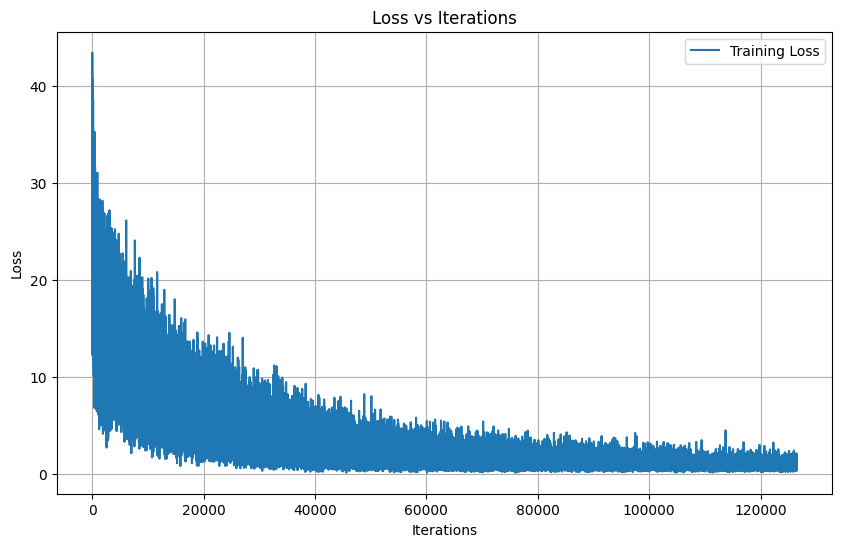

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(len(losses)), losses, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs Iterations')
plt.legend()
plt.grid()
plt.show()


Métricas Generales

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss

def evaluate_model(model, loader):

    model.eval()  # Cambiar a modo evaluación
    all_preds = []  # Predicciones del modelo
    all_probs = []  # Probabilidades
    all_targets = []  # Valores reales

    with torch.no_grad():
        for xi, xv, y in loader:
            xi = xi.to(model.device)
            xv = xv.to(model.device)
            y = y.to(model.device)

            outputs = model(xi, xv).cpu().numpy()  # Predicciones del modelo (logits)
            probs = 1 / (1 + np.exp(-outputs))  # Convertir logits a probabilidades (sigmoide)

            preds = (probs > 0.5).astype(int)  # Umbral para clasificar
            all_preds.extend(preds.flatten())  # Predicciones binarias
            all_probs.extend(probs.flatten())  # Probabilidades
            all_targets.extend(y.cpu().numpy().flatten())  # Valores reales

    # Calcular métricas
    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds)
    recall = recall_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds)
    auc = roc_auc_score(all_targets, all_probs)
    logloss = log_loss(all_targets, all_probs)

    metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC": auc,
        "LogLoss": logloss,
    }

    # Imprimir métricas
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    return metrics

# Evaluar el modelo con el conjunto de validación o prueba
evaluate_model(model, loader_val)


Accuracy: 0.4572
Precision: 0.2145
Recall: 0.6380
F1-Score: 0.3211
AUC: 0.5607
LogLoss: 1.7266


{'Accuracy': 0.45718213519313305,
 'Precision': 0.21451386943121323,
 'Recall': 0.638,
 'F1-Score': 0.3210736003355001,
 'AUC': 0.5606737988303112,
 'LogLoss': 1.7265687517098323}

# NDCG

In [41]:
def precision_at_k(r, k):
    assert 1 <= k <= r.size
    return (np.asarray(r)[:k] != 0).mean()

def average_precision_at_k(r, k):
    r = np.asarray(r)
    score = 0.
    for i in range(min(k, r.size)):
        score += precision_at_k(r, i + 1)
    return score / k

def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.

def idcg_at_k(k):
    return dcg_at_k(np.ones(k), k)

def ndcg_at_k(r, k, max_relevant):
    idcg = idcg_at_k(min(k, max_relevant))
    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

def recall_at_k(relevant_items, recommended_items, k):
    relevant_items = set(relevant_items)
    recommended_items = set(recommended_items[:k])
    intersection = relevant_items.intersection(recommended_items)
    recall = len(intersection) / len(relevant_items) if len(relevant_items) > 0 else 0
    return recall

In [42]:
def evaluate_ranking_deepfm_model(model, loader_val, k, user_items_test):
    model.eval()  # Cambia a modo evaluación
    mean_ap, mean_ndcg, mean_recall = 0., 0., 0.

    for playlist_id, relevant_items in user_items_test.items():
        if not relevant_items:
            continue  # Ignorar playlists sin ítems relevantes

        # Inicializar scores y track_ids
        scores = np.array([], dtype=np.float32)  # Asegura que scores sea un arreglo vacío
        track_ids = []

        for xi, xv, y in loader_val:
            xi = xi.to(model.device)
            xv = xv.to(model.device)

            mask = xi[:, 0, 0] == playlist_id  # Filtrar solo filas del playlist actual
            if mask.sum() == 0:
                continue

            xi_filtered = xi[mask]
            xv_filtered = xv[mask]

            with torch.no_grad():
                preds = model(xi_filtered, xv_filtered).cpu().numpy()
                preds = np.atleast_1d(preds.squeeze())  # Asegura que preds sea 1D

            # Concatenar scores y track_ids
            if scores.size > 0:
                scores = np.concatenate([scores, preds])
            else:
                scores = preds
            track_ids.extend(xi_filtered[:, 1, 0].cpu().numpy())

        # Verifica consistencia de scores y track_ids
        if len(scores) != len(track_ids):
            print(f"ERROR: Length mismatch - scores: {len(scores)}, track_ids: {len(track_ids)}")
            continue

        # Ordenar scores y generar recomendaciones
        sorted_indices = np.argsort(scores)[::-1]  # Índices en orden descendente
        unique_recommended_items = set()
        recommended_items = []

        for idx in sorted_indices:
            item_id = track_ids[int(idx)]  # Asegura que el índice sea correcto
            if item_id not in unique_recommended_items:
                recommended_items.append(item_id)
                unique_recommended_items.add(item_id)
            if len(recommended_items) == k:  # Limitar a k recomendaciones
                break

        # Generar vector de relevancia
        rel_vector = np.isin(recommended_items, relevant_items, assume_unique=True).astype(int)

        # Calcular métricas
        mean_ap += average_precision_at_k(rel_vector, k)
        mean_ndcg += ndcg_at_k(rel_vector, k, len(relevant_items))
        mean_recall += recall_at_k(relevant_items, recommended_items, k)


    # Promediar métricas
    num_playlists = len(user_items_test)
    if num_playlists > 0:
        mean_ap /= num_playlists
        mean_ndcg /= num_playlists
        mean_recall /= num_playlists

    return mean_ap, mean_ndcg, mean_recall


In [43]:
# Filtrar canciones relevantes (target = 1) en test_set
relevant_items_test = test_set[test_set['target'] == 1]

# Construir user_items_test
user_items_test = relevant_items_test.groupby('playlist_id')['track_id'].apply(list).to_dict()


In [44]:
k = 10
mean_ap, mean_ndcg, mean_recall = evaluate_ranking_deepfm_model(model, loader_val, k, user_items_test)

print(f"Mean Average Precision (MAP): {mean_ap:.4f}")
print(f"Mean NDCG: {mean_ndcg:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")


Mean Average Precision (MAP): 0.1989
Mean NDCG: 0.2009
Mean Recall: 0.0687


In [45]:
k = 20
mean_ap, mean_ndcg, mean_recall = evaluate_ranking_deepfm_model(model, loader_val, k, user_items_test)

print(f"Mean Average Precision (MAP): {mean_ap:.4f}")
print(f"Mean NDCG: {mean_ndcg:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")

Mean Average Precision (MAP): 0.2011
Mean NDCG: 0.1997
Mean Recall: 0.1351


## HR

In [46]:
def hit_rate_at_k(user_items_test, model, loader_val, k):
    model.eval()  # Cambia el modelo a modo evaluación
    total_hits = 0  # Contador de éxitos
    total_playlists = len(user_items_test)  # Número total de playlists

    for playlist_id, relevant_items in user_items_test.items():
        if not relevant_items:
            continue  # Ignorar playlists sin ítems relevantes

        # Obtener las recomendaciones
        recommended_items = get_recommendations_for_playlist(model, playlist_id, loader_val, k)

        # Verificar si hay un hit
        if any(item in relevant_items for item in recommended_items):
            total_hits += 1

    # Calcular HR@k
    hr = total_hits / total_playlists if total_playlists > 0 else 0
    return hr

In [47]:
# Ejemplo de uso
k = 10
hr_10 = hit_rate_at_k(user_items_test, model, loader_val, k)
print(f"Hit Rate @ {k}: {hr_10:.4f}")

NameError: name 'get_recommendations_for_playlist' is not defined

# Diversidad

In [ ]:
def get_recommendations_for_playlist(model, playlist_id, loader_val, k):

    model.eval()
    scores = np.array([], dtype=np.float32)
    track_ids = []

    for xi, xv, y in loader_val:
        xi = xi.to(model.device)
        xv = xv.to(model.device)

        # Filtrar las filas relevantes para el playlist_id
        mask = xi[:, 0, 0] == playlist_id
        if mask.sum() == 0:
            continue

        xi_filtered = xi[mask]
        xv_filtered = xv[mask]

        with torch.no_grad():
            preds = model(xi_filtered, xv_filtered).cpu().numpy()
            preds = np.atleast_1d(preds.squeeze())

        # Concatenar predicciones
        if scores.size > 0:
            scores = np.concatenate([scores, preds])
        else:
            scores = preds

        track_ids.extend(xi_filtered[:, 1, 0].cpu().numpy())

    # Ordenar por score descendente
    sorted_indices = np.argsort(scores)[::-1]
    recommended_items = [track_ids[idx] for idx in sorted_indices[:k]]

    return recommended_items

In [ ]:
def diversity(recommended_items, item_categories):

    unique_categories = set()
    for item in recommended_items:
        categories = item_categories.get(item, [])
        if isinstance(categories, list):
            unique_categories.update(categories)
        else:
            unique_categories.add(categories)
    return len(unique_categories) / len(recommended_items) if recommended_items else 0

Pendiente: calcular diversidad en base a alguna categoría

In [ ]:
# Ejemplo de uso:
playlist_id = 3  # ID de la playlist para evaluar
k = 10  # Número de recomendaciones
recommended_items = get_recommendations_for_playlist(model, playlist_id, loader_val, k)

# Diccionario de categorías por canción
#item_categories = songs_metadata.set_index('track_id')['genre'].to_dict()  # Reemplaza 'genre' con tu atributo

# Calcula diversidad
diversidad = diversity(recommended_items, item_categories)
print(f"Recomendaciones para playlist {playlist_id}: {recommended_items}")
print(f"Diversidad: {diversidad:.4f}")

# Novedad

In [ ]:
def calculate_items_popularity(train_set):
    item_counts = train_set['track_id'].value_counts()
    total_interacciones = len(train_set)
    items_popularity = (item_counts / total_interacciones).to_dict()
    return items_popularity

def novelty(recommended_items, items_popularity):
    novelty_score = 0
    for item in recommended_items:
        popularity = items_popularity.get(item, 1e-6)  # Asume mínima popularidad para ítems desconocidos
        novelty_score += np.log(1 / popularity)
    return novelty_score / len(recommended_items) if recommended_items else 0

In [ ]:
# Calcular la popularidad de los ítems a partir del conjunto de entrenamiento
items_popularity = calculate_items_popularity(train_set)

# Obtener las recomendaciones para una playlist específica
playlist_id = 2  # ID de la playlist para evaluar
k = 10  # Número de recomendaciones
recommended_items = get_recommendations_for_playlist(model, playlist_id, loader_val, k)

# Calcular la novedad de las recomendaciones
novedad = novelty(recommended_items, items_popularity)
print(f"Novedad para playlist {playlist_id}: {novedad:.4f}")

In [ ]:
total_novedad = 0
for playlist_id in user_items_test.keys():
    recommended_items = get_recommendations_for_playlist(model, playlist_id, loader_val, k)
    total_novedad += novelty(recommended_items, items_popularity)
promedio_novedad = total_novedad / len(user_items_test)
print(f"Novedad promedio: {promedio_novedad:.4f}")

In [ ]:
# Crear diccionarios de mapeo revertidos
original_playlist_map = {v: k for k, v in playlist_map.items()}
original_track_map = {v: k for k, v in track_map.items()}


In [ ]:
import json

def generate_original_recommendations(model, loader_val, test_set, k=25):
    model.eval()  # Cambia a modo evaluación
    recommendations = {}

    # Obtener las playlists únicas del conjunto de prueba
    playlist_ids = test_set['playlist_id'].unique()

    for playlist_id in playlist_ids:
        # Generar las recomendaciones para la playlist actual (IDs mapeados)
        recommended_items = get_recommendations_for_playlist(model, playlist_id, loader_val, k)

        # Revertir los IDs de tracks y playlists a los originales
        original_playlist_id = original_playlist_map[playlist_id]
        original_recommended_items = [original_track_map[track_id] for track_id in recommended_items]

        # Guardar en el diccionario con IDs originales
        recommendations[original_playlist_id] = original_recommended_items

    return recommendations



In [ ]:
def save_recommendations_to_json(recommendations, output_file):
    # Convertir llaves a cadenas para asegurar compatibilidad con JSON
    recommendations_str_keys = {str(key): value for key, value in recommendations.items()}

    # Guardar las recomendaciones en un archivo JSON
    with open(output_file, 'w') as json_file:
        json.dump(recommendations_str_keys, json_file, indent=4)

    print(f"Archivo JSON generado en: {output_file}")

In [ ]:
recommendations = generate_original_recommendations(model, loader_val, test_set, k=25)


In [ ]:
# Ruta del archivo de salida
output_file = '/content/drive/MyDrive/Colab Notebooks/RecSys/data/deepfm_feature_recomendations.json'


# Generar archivo JSON con 25 recomendaciones por playlist
save_recommendations_to_json(recommendations, output_file)

In [ ]:
mapped_json = '/content/drive/MyDrive/Colab Notebooks/RecSys/data/deepfm_feature_recomendations.json'


In [ ]:
def load_and_revert_mapping(input_file, output_file):
    # Cargar el archivo JSON con las recomendaciones mapeadas
    with open(input_file, 'r') as json_file:
        mapped_data = json.load(json_file)

    # Aplicar la reversión del mapeo
    reverted_data = {
        int(original_playlist_map[int(playlist_id)]): [
            int(original_track_map[int(track_id)]) for track_id in track_ids
        ]
        for playlist_id, track_ids in mapped_data.items()
    }

    # Guardar el archivo revertido en formato JSON
    with open(output_file, 'w') as json_file:
        print(reverted_data)
        json.dump(reverted_data, json_file, indent=4)

    print(f"Archivo revertido guardado en: {output_file}")
    return reverted_data

# Archivos de entrada y salida
output_file = '/content/drive/MyDrive/Colab Notebooks/RecSys/data/deepfm_feature_recomendations_reverted.json'

# Aplicar la reversión del mapeo
reverted_data = load_and_revert_mapping(mapped_json, output_file)